<a href="https://colab.research.google.com/github/pupkinivan/fsd-tagging/blob/master/ladifanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación

In [0]:
        # Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import os

# Access Drive from Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Preprocessing

In [0]:
# Preprocessing libraries
import librosa.feature as lrft
# from librosa import load as lbload
from librosa.display import specshow
import librosa.display
import librosa as lr
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import stft
from zipfile import ZipFile
import IPython.display

import matplotlib.pyplot as plt

## Neural networks

In [0]:
# Libraries for neural nets
from fastai import *
from fastai.vision import *
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable

## XGBoost & ML

In [0]:
# XGBoost
import xgboost as xgb
# from sklearn.model_selection import train_test_split

# Preprocessing


**FALTA:**

**1. ver cómo deben estructurarse los directorios para fastai**

### Flujo del preprocesamiento
1.   Transformación:
    *   codificación a mp3 para data augmentation?
    *   se cargan los archivos de audio, se transforman en paralelo a: melspectrogram y double-tree continuous wavelet transform (DT-CWT). Se guardan los espectrogramas, los que se usarán como base de datos de entrenamiento. Para ello es necesario que los directorios cumplan los requisitos de lectura de la librería fastai.

2.   Procesamiento:
    *   Eliminación de silencios: se divide los archivos en segmentos no silenciosos y se descartan los silenciosos
    *   Padding: se unifican las dimensiones de los archivos

3.   MixUp: se usa la técnica mixup durante el entrenamiento tal como está implementada en la librería fastai.

#### Opción alternativa: crear ItemBase y ItemList
importar audios como ItemList de ItemBase => aplicar transformaciones

## Feature engineering:
Para crear más features y/o ayudar a la regularización gracias a domain knowledge, ideas posibles para transformar los audios son:
- **Transformaciones típicas**: melspectrograma, coeficientes mel, transformada Q constante, transformada wavelets. La primera ha dado mejores resultados en redes neuronales. MFCC fuerza ortogonalidad lo que podría obstaculizar la generalización.
- **Conversión a mp3**: menor espacio en disco, menores tiempos de carga a memoria, posibles beneficios en cuanto a regularización por pérdida de "definición", por ponerle un nombre.
- **Traslaciones en frecuencia**: data augmentation y regularización por "deformar" features.
- **Cortar audios** en pequeños segmentos de misma duración: además de ser necesario para el funcionamiento de la red neuronal convolutiva, permite data augmentation sin modificar la distribución de los datos.

In [0]:
""" Acomodar directorios a carpetas de audios.
"""
# os.getcwd()
# os.chdir("../input")  # kaggle/input
os.listdir()

### Importación de datos

In [0]:
sr, audio = read("Pulso_15ms.wav")
# audio, sr = lbload("Pulso_15ms.wav", sr=None, dtype=np.float32)
# , mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>,
# res_type='kaiser_best')

# Chequeo porque librosa es una mierda
print(audio.shape)
print(audio[1000:1010])
print(audio[:10])
print(type(audio))
audio
audio.dtype
audio = audio.astype(np.int32)
audio.shape
# audio = np.array(audio / 32767)
audio = np.round(audio * 32767)
plt.plot(audio)

### wav -> mp3
La idea es usar la conversión a mp3 para aprovechar su alinealidad y los parámetros que tal formato pondera del oído humano para acercar al modelo a la human level performance.

In [0]:
# os.getcwd()
# path_curated = os.getcwd() + "/train_curated"
# print(path_curated)
# os.listdir(path_curated)

# file = path_curated + 'a17b177a.wav'
# cmd = 'lame --preset insane %s' % file
# subprocess.call(cmd, shell=True)
# print('a17b177a.wav.mp3' in os.listdir(path_curated))

# os.chdir('train_curated')
# os.getcwd()
file = 'a17b177a.wav'
cmd = 'lame --preset insane %s' % file
subprocess.call(cmd, shell=True)
print('a17b177a.wav.mp3' in os.listdir())

# for file in os.listdir(path+"/train_curated"):
#     # chequear que file es "str.wav"
#     cmd = 'lame --preset insane %s' % file
#     subprocess.call(cmd, shell=True)
#     cmd = 'mpg123 -w %s_tfmd.wav %s.wav.mp3' % file[:-4]  # necesita una pausa?
#     subprocess.call(cmd, shell=True)

### Melspectrogram

Audio -> STFT -> melspectrogram

**FALTA en la transformación:**
- Que se realice sobre TODOS los archivos
- Guardar en una estructura de directorios que simplifique la importación por fastai

#### Implementación de alguien

In [0]:
def read_audio(conf, pathname, trim_long_data):
   y, sr = librosa.load(pathname, sr=conf.sampling_rate)
   # trim silence
   if 0 < len(y): # workaround: 0 length causes error
       y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
   # make it unified length to conf.samples
   if len(y) > conf.samples: # long enough
       if trim_long_data:
           y = y[0:0+conf.samples]
   else: # pad blank
       padding = conf.samples - len(y)    # add padding at both ends
       offset = padding // 2
       y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
   return y

def audio_to_melspectrogram(conf, audio):
   spectrogram = librosa.feature.melspectrogram(audio,
                                                sr=conf.sampling_rate,
                                                n_mels=conf.n_mels,
                                                hop_length=conf.hop_length,
                                                n_fft=conf.n_fft,
                                                fmin=conf.fmin,
                                                fmax=conf.fmax)
   spectrogram = librosa.power_to_db(spectrogram)
   spectrogram = spectrogram.astype(np.float32)
   return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
   librosa.display.specshow(mels, x_axis='time', y_axis='mel',
                            sr=conf.sampling_rate, hop_length=conf.hop_length,
                           fmin=conf.fmin, fmax=conf.fmax)
   plt.colorbar(format='%+2.0f dB')
   plt.title(title)
   plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
   x = read_audio(conf, pathname, trim_long_data)
   mels = audio_to_melspectrogram(conf, x)
   if debug_display:
       IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
       show_melspectrogram(conf, mels)
   return mels


class conf:
   # Preprocessing settings
   sampling_rate = 44100
   duration = 2
   hop_length = 347*duration # to make time steps 128
   fmin = 20
   fmax = sampling_rate // 2
   n_mels = 128
   n_fft = n_mels * 20
   samples = sampling_rate * duration

# example
# x = read_as_melspectrogram(conf, TRN_CURATED/'0006ae4e.wav', trim_long_data=False, debug_display=True)

#### Otra (sin terminar)

In [0]:
# SciPy STFT
for file in path.ls():
    sr, audio = read(file)
    f, t, spec = stft(audio, window='hann', nperseg=n_fft, return_onesided=True,
                  padded=True, axis=-1)
    melspec = lrft.melspectrogram(S=spec, sr=sr, n_fft=n_fft,
                              hop_length=hop_length, power=power)
    # implementar el guardado de la "imagen" del melspec

def addZip(directory):
   file_paths = get_all_file_paths(directory)
   with ZipFile('mijormi.zip', 'w') as zip:
       for file in file_paths:
           zip.write(file)

# f, t, spec = stft(audio, window='hann', nperseg=n_fft, return_onesided=True,
#                   padded=True, axis=-1)
# # Ploteo
# specshow(lr.amplitude_to_db(spec), y_axis='mel', x_axis='time', fmax=20000)
# plt.colorbar(format='%+2.0f dB')
# plt.title('STFT spectrogram')
# plt.tight_layout()

# # Librosa melspectrogram
# melspec = lrft.melspectrogram(S=spec, sr=sr, n_fft=n_fft,
#                               hop_length=hop_length, power=power)
# # Ploteo
# specshow(lr.amplitude_to_db(melspec, ref=np.max),
#          y_axis='mel', x_axis='time', fmax=20000)
# plt.colorbar(format='%+2.0f dB')
# plt.title('Mel spectrogram')
# plt.tight_layout()

# Librosa STFT o melspectrogram de una son una mierda
# spec = lr.stft(audio, n_fft=n_fft, hop_length=hop_length, center=False)
# , dtype=<class 'numpy.complex64'>, pad_mode='reflect')

# Esto anda como el orto. No acepta ni int ni float
# melspec = lrft.melspectrogram(y=audio, sr=sr, n_fft=n_fft,
#                                      hop_length=hop_length, power=power)

### Eliminación de silencio

División en segmentos, promediado RMS, eliminación de segmentos silenciosos, conservación de segmentos no silenciosos con segmentos adyacentes.

**FALTA:**
* **Programar que corra sobre todos los archivos de un set de datos**
* **Hacer que funcione correctamente en simultáneo para espectrogramas "RGB"**
* **Implementar manejo de dimensiones de salida (según cantidad de segmentos sonoros detectados)**


La función que se debe llamar para cada archivo es del_silence(). Las otras que figuran a continuación son llamadas por ella como parte del proceso.

    del_silence(spec: [array] espectrograma, seg_frames: [int] duración de segmentos, thresh=-60 [int/float] umbral de silencio en dB)

#### NumPy


In [0]:
def rms(spec, idx, n_fft, on='amplitude'):
    """ RMS of a single frame of a spectrogram
    """
    if on == 'magnitude':
        return 10 * np.log10(np.sum(np.power(10, spec[:, idx] * 0.1)))
    elif on == 'amplitude':
        return np.sqrt(np.sum(spec[:, idx] ** 2) / n_fft)
    else:
        raise ValueError("Expected \"amplitude/magnitude\", got ", on, ".")

def del_silence(spec, n_fft, on='amplitude', thresh=1.e-6):
    """ Delete silent segments in spectrograms.
    
    Arguments:
    spec - array of shape (n_mel or n_fft, n_frames, 3). El espectrograma
        de amplitud debe ser el canal 0, es a partir del que se hace el
        filtrado de silencios.
    n_fft - int. Number of frequency bins.
    
    Returns:
    non_silent_segments - array of shape (n_mel or n_fft, N, 3) where N
        is the number of non-silent frames found.
    """
    non_silent_segments = []
    split = spec
    prevsil = True
    t = 0
    while True:
        RMS = rms(split, t, n_fft, on=on)
        if (RMS < thresh) and not prevsil:
            # si pasa de sonido a silencio
            split = np.split(split, [t+1], axis=1)  # [t+1] por padding
            if t % 50 == 0:
                print(split[0])
            non_silent_segments.append(np.squeeze(split[0]))
            t -= split[0].shape[1]  # chequear
            # del split[0]
            split = split[1]            
            prevsil = True

        elif (RMS >= thresh) and prevsil:
            # si viene de silencio y pasa a sonido
            # padding por un frame a la izquierda
            split = np.split(split, [t], axis=1)  # [t] por padding
            if split[0].shape[1] == 0:
                t -= 1
            t -= split[0].shape[1] - 1  # -1 por padding, chequear
            # del split[0]
            split = split[1]
            prevsil = False

        elif (RMS < thresh) and prevsil:
            # si viene de silencio y sigue en silencio
            prevsil = True

        else:
            # si viene de sonido y sigue con sonido
            prevsil = False
        
        t += 1
        if t >= split.shape[1]:
            if prevsil == False:
                non_silent_segments.append(np.squeeze(split))
            break
    return np.array(non_silent_segments)
    

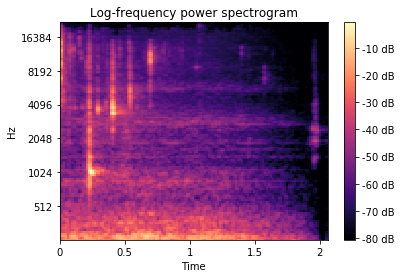

(128, 131)


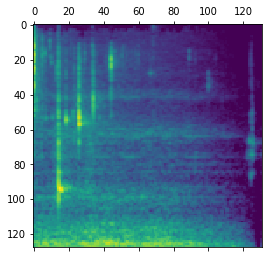

In [0]:
# PRUEBA
# os.chdir('gdrive/My Drive/Colab Notebooks/Freesound tagging/train_curated')
# os.listdir()

audio = read_as_melspectrogram(conf, '0019ef41.wav', trim_long_data=False, debug_display=True)
nonsil = del_silence(audio, conf.n_fft, on='magnitude', thresh=-60)
print(nonsil.shape)
# mini = np.amin(np.amin(nonsil))
# nonsil = nonsil - np.min(np.min(nonsil))
# specshow(nonsil[0])
plt.matshow(nonsil[::-1, :])

#### Recursivas (no funcionan)

In [0]:
# IMPLEMENTACION RECURSIVA NO FUNCIONA (del_silence, las otras tal vez sí)

np.seterr(divide='ignore', invalid='ignore')

def is_silent(segment, thresh=-60):
    """ Self explanatory. Threshold in dB.
    """
#     length = segment.shape[1]
    rmsperfreq = np.sqrt(np.sum(np.array(segment) ** 2, axis=1))
    rms = 10. * np.log10(np.sum(np.power(10, rmsperfreq * 0.1)))
    return True if rms < thresh else False


def next_silent(spec, idx, thresh=-60):
    """ Recursive implementation of silent segments detection.
    """
    
    if idx + 1 >= spec.shape[1]:
        return idx
    
    temp = spec[:, idx: idx+1]
    issil = is_silent(temp, thresh=thresh)
    
    if not issil:
        next_silent_idx = next_silent(spec, idx+1, thresh)
        if idx == next_silent_idx:
            return idx
        else:
            return next_silent_idx
    else:
        return idx


def next_nonsilent(spec, idx, thresh=-60):
    """ Recursive implementation of non-silent segments detection.
    """
    if idx + 1 >= spec.shape[1]:
        return idx

    temp = spec[:, idx: idx+1]
    issil = is_silent(temp, thresh=thresh)
    
    if issil:
        next_nonsilent_idx = next_nonsilent(spec, idx+1, thresh)
        if idx == next_nonsilent_idx:
            return idx
        else:
            return next_nonsilent_idx
    else:
        return idx


def del_silence(spec, thresh=-60):
    """ Delete frames of duration seg_frames under magnitude thresh and returns
    a list of non-silent frames.
    
    Args:
    spec: array. Time should be axis 1, frequencies axis 0.
    seg_frames: int. Segment duration in number of spectrogram frames.
    thresh: float/int. Magnitude threshold.
    
    Returns:
    non_silent_segments: array of shape" (n, freqs, seg_frames), where n is the
        number of non-silent segments found, and freqs is the frequency
        resolution of the input spec.
    """
    nonsilent_segments = []

    if is_silent(spec[:, :2], thresh=thresh):
        last_sil_idx = 0
        while True:
            nonsil_idx = next_nonsilent(spec, last_sil_idx + 1, thresh=thresh)
            nxt_sil_idx = next_silent(spec, nonsil_idx, thresh=thresh)
            if last_sil_idx == nxt_sil_idx:
                break
            last_sil_idx = nonsil_idx - 1
            nonsilent_segments.append([spec[:, last_sil_idx: nxt_sil_idx + 1]])
            last_sil_idx = nxt_sil_idx
    else:
        nonsil_idx = 0
        last_sil_idx = 0
        while True:
            nxt_sil_idx = next_silent(spec, nonsil_idx, thresh=thresh)
            if nxt_sil_idx == nonsil_idx:
                break
            nonsilent_segments.append([spec[:, last_sil_idx: nxt_sil_idx + 1]])
            nonsil_idx = next_nonsilent(spec, last_sil_idx + 1, thresh=thresh)
            last_sil_idx = nonsil_idx - 1
    return nonsilent_segments

NameError: ignored

#### Proceso de eliminación de silencio

**Falta completar**

Se llama a la función de eliminación de silencios sobre los archivos cargados y transformados.

In [0]:
for spec in specs:
    nonsilsegs = del_silence(spec, frame_samps, thresh=-60)
    # separar nonsilsegs en cada segmento no silencioso

### Padding

Se lleva los segmentos con el silencio ya filtrado a un largo uniforme para todo el dataset. Las dimensiones deben cumplir con los requisitos de los modelos preimplementados por PyTorch y FastAI en tales casos.

In [0]:
# implementar para cada archivo
# for file in files:

# impar = (w_stip - w_file) % 2
# para asegurar coincidencia exacta con ancho estipulado

# np.pad(array, ((pad_width // 2, pad_width // 2 + impar * 1),  # R
#                (pad_width // 2, pad_width // 2 + impar * 1),  # G
#                (pad_width // 2, pad_width // 2 + impar * 1)),  # B
#                mode='constant')

# Modelos

Se pretende usar distintas transformaciones de los audios a espectrograma para entrenar varias arquitecturas de redes neuronales en paralelo. El resultado de las redes neuronales confluye en un algoritmo de boosting (XGBoost?) que aprende de los éxitos y fracasos de las redes para continuar minimizando el error.

## CNNs

Se usarían, por ahora, MobileNet v2, NASNet Mobile, SqueezeNet, ShuffleNet v2 y WideResNet.

### MobileNet v2
Based on Tony Lins' implementation:
https://github.com/tonylins/pytorch-mobilenet-v2

**Modificar las dimensiones de acuerdo a las de preprocesamiento de los datos.**


#### Blocks

In [0]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                         nn.BatchNorm2d(oup),
                         nn.ReLU6(inplace=True))

def conv_1x1_bn(inp, oup):
    return nn.Sequential(nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                         nn.BatchNorm2d(oup),
                         nn.ReLU6(inplace=True))


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(  # dw
                                      nn.Conv2d(hidden_dim, hidden_dim, 3,
                                                stride, 1, groups=hidden_dim,
                                                bias=False),
                                      nn.BatchNorm2d(hidden_dim),
                                      nn.ReLU6(inplace=True),
                                      # pw-linear
                                      nn.Conv2d(hidden_dim, oup, 1,
                                                1, 0, bias=False),
                                      nn.BatchNorm2d(oup))
        else:
            self.conv = nn.Sequential(  # pw
                                      nn.Conv2d(inp, hidden_dim, 1, 1, 0,
                                                bias=False),
                                      nn.BatchNorm2d(hidden_dim),
                                      nn.ReLU6(inplace=True),
                                      # dw
                                      nn.Conv2d(hidden_dim, hidden_dim, 3,
                                                stride, 1, bias=False
                                                groups=hidden_dim),
                                      nn.BatchNorm2d(hidden_dim),
                                      nn.ReLU6(inplace=True),
                                      # pw-linear
                                      nn.Conv2d(hidden_dim, oup, 1, 1, 0,
                                                bias=False),
                                      nn.BatchNorm2d(oup))

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

#### Model

In [0]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) \
            if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel,
                                               s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel,
                                               1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

### NASNet Mobile
Based on the implementation by Veronika Yurchuk:
https://github.com/veronikayurchuk/pretrained-models.pytorch/blob/master/pretrainedmodels/models/nasnet_mobile.py

#### Settings
**Modificar la normalización (mean, std), las dimensiones de entrada según las especificaciones de duración y melspectrogram (input_size) e input_space que ni puta idea de qué es.**

In [0]:
settings = {
    'nasnetamobile': {
        'no_pretraining': {
            'input_space': 'RGB',
            'input_size': [3, 224, 224], # resize 256
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 80
        }
    }
}

#### Blocks

In [0]:
class MaxPoolPad(nn.Module):
    def __init__(self):
        super(MaxPoolPad, self).__init__()
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x):
        x = self.pad(x)
        x = self.pool(x)
        x = x[:, :, 1:, 1:].contiguous()
        return x


class AvgPoolPad(nn.Module):
    def __init__(self, stride=2, padding=1):
        super(AvgPoolPad, self).__init__()
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.pool = nn.AvgPool2d(3, stride=stride, padding=padding, count_include_pad=False)

    def forward(self, x):
        x = self.pad(x)
        x = self.pool(x)
        x = x[:, :, 1:, 1:].contiguous()
        return x


class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dw_kernel, dw_stride, dw_padding, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise_conv2d = nn.Conv2d(in_channels, in_channels, dw_kernel,
                                          stride=dw_stride,
                                          padding=dw_padding,
                                          bias=bias,
                                          groups=in_channels)
        self.pointwise_conv2d = nn.Conv2d(in_channels, out_channels, 1, stride=1, bias=bias)

    def forward(self, x):
        x = self.depthwise_conv2d(x)
        x = self.pointwise_conv2d(x)
        return x


class BranchSeparables(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, name=None, bias=False):
        super(BranchSeparables, self).__init__()
        self.relu = nn.ReLU()
        self.separable_1 = SeparableConv2d(in_channels, in_channels, kernel_size, stride, padding, bias=bias)
        self.bn_sep_1 = nn.BatchNorm2d(in_channels, eps=0.001, momentum=0.1, affine=True)
        self.relu1 = nn.ReLU()
        self.separable_2 = SeparableConv2d(in_channels, out_channels, kernel_size, 1, padding, bias=bias)
        self.bn_sep_2 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)
        self.name = name

    def forward(self, x):
        x = self.relu(x)
        if self.name == 'specific':
            x = nn.ZeroPad2d((1, 0, 1, 0))(x)
        x = self.separable_1(x)
        if self.name == 'specific':
            x = x[:, :, 1:, 1:].contiguous()

        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class BranchSeparablesStem(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        super(BranchSeparablesStem, self).__init__()
        self.relu = nn.ReLU()
        self.separable_1 = SeparableConv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bn_sep_1 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)
        self.relu1 = nn.ReLU()
        self.separable_2 = SeparableConv2d(out_channels, out_channels, kernel_size, 1, padding, bias=bias)
        self.bn_sep_2 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.separable_1(x)
        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class BranchSeparablesReduction(BranchSeparables):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, z_padding=1, bias=False):
        BranchSeparables.__init__(self, in_channels, out_channels, kernel_size, stride, padding, bias)
        self.padding = nn.ZeroPad2d((z_padding, 0, z_padding, 0))

    def forward(self, x):
        x = self.relu(x)
        x = self.padding(x)
        x = self.separable_1(x)
        x = x[:, :, 1:, 1:].contiguous()
        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class CellStem0(nn.Module):
    def __init__(self, stem_filters, num_filters=42):
        super(CellStem0, self).__init__()
        self.num_filters = num_filters
        self.stem_filters = stem_filters
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2)
        self.comb_iter_0_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(self.num_filters, self.num_filters, 3, 1, 1, bias=False)
        self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x):
        x1 = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x1)
        x_comb_iter_0_right = self.comb_iter_0_right(x)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x1)
        x_comb_iter_1_right = self.comb_iter_1_right(x)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x1)
        x_comb_iter_2_right = self.comb_iter_2_right(x)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x1)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class CellStem1(nn.Module):
    def __init__(self, stem_filters, num_filters):
        super(CellStem1, self).__init__()
        self.num_filters = num_filters
        self.stem_filters = stem_filters
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(2*self.num_filters, self.num_filters, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True))

        self.relu = nn.ReLU()
        self.path_1 = nn.Sequential()
        self.path_1.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_1.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters//2, 1, stride=1, bias=False))
        self.path_2 = nn.ModuleList()
        self.path_2.add_module('pad', nn.ZeroPad2d((0, 1, 0, 1)))
        self.path_2.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_2.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters//2, 1, stride=1, bias=False))

        self.final_path_bn = nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True)

        self.comb_iter_0_left = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2, name='specific', bias=False)
        self.comb_iter_0_right = BranchSeparables(self.num_filters, self.num_filters, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparables(self.num_filters, self.num_filters, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2, name='specific', bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(self.num_filters, self.num_filters, 3, 1, 1, name='specific', bias=False)
        # self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_4_right = MaxPoolPad()

    def forward(self, x_conv0, x_stem_0):
        x_left = self.conv_1x1(x_stem_0)

        x_relu = self.relu(x_conv0)
        # path 1
        x_path1 = self.path_1(x_relu)
        # path 2
        x_path2 = self.path_2.pad(x_relu)
        x_path2 = x_path2[:, :, 1:, 1:]
        x_path2 = self.path_2.avgpool(x_path2)
        x_path2 = self.path_2.conv(x_path2)
        # final path
        x_right = self.final_path_bn(torch.cat([x_path1, x_path2], 1))

        x_comb_iter_0_left = self.comb_iter_0_left(x_left)
        x_comb_iter_0_right = self.comb_iter_0_right(x_right)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_right)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_left)
        x_comb_iter_2_right = self.comb_iter_2_right(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_left)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class FirstCell(nn.Module):
    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(FirstCell, self).__init__()
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.relu = nn.ReLU()
        self.path_1 = nn.Sequential()
        self.path_1.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.path_2 = nn.ModuleList()
        self.path_2.add_module('pad', nn.ZeroPad2d((0, 1, 0, 1)))
        self.path_2.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_2.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))

        self.final_path_bn = nn.BatchNorm2d(out_channels_left * 2, eps=0.001, momentum=0.1, affine=True)

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

        self.comb_iter_1_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_1_right = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_3_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)
        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

    def forward(self, x, x_prev):
        x_relu = self.relu(x_prev)
        # path 1
        x_path1 = self.path_1(x_relu)
        # path 2
        x_path2 = self.path_2.pad(x_relu)
        x_path2 = x_path2[:, :, 1:, 1:]
        x_path2 = self.path_2.avgpool(x_path2)
        x_path2 = self.path_2.conv(x_path2)
        # final path
        x_left = self.final_path_bn(torch.cat([x_path1, x_path2], 1))

        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_left

        x_comb_iter_3_left = self.comb_iter_3_left(x_left)
        x_comb_iter_3_right = self.comb_iter_3_right(x_left)
        x_comb_iter_3 = x_comb_iter_3_left + x_comb_iter_3_right

        x_comb_iter_4_left = self.comb_iter_4_left(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_right

        x_out = torch.cat([x_left, x_comb_iter_0, x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class NormalCell(nn.Module):
    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(NormalCell, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_left, out_channels_left, 3, 1, 1, bias=False)

        self.comb_iter_1_left = BranchSeparables(out_channels_left, out_channels_left, 5, 1, 2, bias=False)
        self.comb_iter_1_right = BranchSeparables(out_channels_left, out_channels_left, 3, 1, 1, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_3_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)
        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_left

        x_comb_iter_3_left = self.comb_iter_3_left(x_left)
        x_comb_iter_3_right = self.comb_iter_3_right(x_left)
        x_comb_iter_3 = x_comb_iter_3_left + x_comb_iter_3_right

        x_comb_iter_4_left = self.comb_iter_4_left(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_right

        x_out = torch.cat([x_left, x_comb_iter_0, x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class ReductionCell0(nn.Module):
    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(ReductionCell0, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparablesReduction(out_channels_right, out_channels_right, 5, 2, 2, bias=False)
        self.comb_iter_0_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparablesReduction(out_channels_right, out_channels_right, 3, 1, 1, bias=False)
        self.comb_iter_4_right = MaxPoolPad()

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_right)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2_right = self.comb_iter_2_right(x_left)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class ReductionCell1(nn.Module):
    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(ReductionCell1, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 2, 2, name='specific', bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_right, out_channels_right, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparables(out_channels_right, out_channels_right, 7, 2, 3, name='specific', bias=False)

        # self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparables(out_channels_right, out_channels_right, 5, 2, 2, name='specific', bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, name='specific', bias=False)
        # self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_4_right =MaxPoolPad()

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_right)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2_right = self.comb_iter_2_right(x_left)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out

#### Model

In [0]:
class NASNetAMobile(nn.Module):
    """NASNetAMobile (4 @ 1056) """
    def __init__(self, num_classes=1001, stem_filters=32, penultimate_filters=1056, filters_multiplier=2):
        super(NASNetAMobile, self).__init__()
        self.num_classes = num_classes
        self.stem_filters = stem_filters
        self.penultimate_filters = penultimate_filters
        self.filters_multiplier = filters_multiplier

        filters = self.penultimate_filters // 24
        # 24 is default value for the architecture

        self.conv0 = nn.Sequential()
        self.conv0.add_module('conv', nn.Conv2d(in_channels=3, out_channels=self.stem_filters, kernel_size=3, padding=0, stride=2,
                                                bias=False))
        self.conv0.add_module('bn', nn.BatchNorm2d(self.stem_filters, eps=0.001, momentum=0.1, affine=True))

        self.cell_stem_0 = CellStem0(self.stem_filters, num_filters=filters // (filters_multiplier ** 2))
        self.cell_stem_1 = CellStem1(self.stem_filters, num_filters=filters // filters_multiplier)

        self.cell_0 = FirstCell(in_channels_left=filters, out_channels_left=filters//2, # 1, 0.5
                                in_channels_right=2*filters, out_channels_right=filters) # 2, 1
        self.cell_1 = NormalCell(in_channels_left=2*filters, out_channels_left=filters, # 2, 1
                                 in_channels_right=6*filters, out_channels_right=filters) # 6, 1
        self.cell_2 = NormalCell(in_channels_left=6*filters, out_channels_left=filters, # 6, 1
                                 in_channels_right=6*filters, out_channels_right=filters) # 6, 1
        self.cell_3 = NormalCell(in_channels_left=6*filters, out_channels_left=filters, # 6, 1
                                 in_channels_right=6*filters, out_channels_right=filters) # 6, 1

        self.reduction_cell_0 = ReductionCell0(in_channels_left=6*filters, out_channels_left=2*filters, # 6, 2
                                               in_channels_right=6*filters, out_channels_right=2*filters) # 6, 2

        self.cell_6 = FirstCell(in_channels_left=6*filters, out_channels_left=filters, # 6, 1
                                in_channels_right=8*filters, out_channels_right=2*filters) # 8, 2
        self.cell_7 = NormalCell(in_channels_left=8*filters, out_channels_left=2*filters, # 8, 2
                                 in_channels_right=12*filters, out_channels_right=2*filters) # 12, 2
        self.cell_8 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters, # 12, 2
                                 in_channels_right=12*filters, out_channels_right=2*filters) # 12, 2
        self.cell_9 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters, # 12, 2
                                 in_channels_right=12*filters, out_channels_right=2*filters) # 12, 2

        self.reduction_cell_1 = ReductionCell1(in_channels_left=12*filters, out_channels_left=4*filters, # 12, 4
                                               in_channels_right=12*filters, out_channels_right=4*filters) # 12, 4

        self.cell_12 = FirstCell(in_channels_left=12*filters, out_channels_left=2*filters, # 12, 2
                                 in_channels_right=16*filters, out_channels_right=4*filters) # 16, 4
        self.cell_13 = NormalCell(in_channels_left=16*filters, out_channels_left=4*filters, # 16, 4
                                  in_channels_right=24*filters, out_channels_right=4*filters) # 24, 4
        self.cell_14 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters, # 24, 4
                                  in_channels_right=24*filters, out_channels_right=4*filters) # 24, 4
        self.cell_15 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters, # 24, 4
                                  in_channels_right=24*filters, out_channels_right=4*filters) # 24, 4

        self.relu = nn.ReLU()
        self.avg_pool = nn.AvgPool2d(7, stride=1, padding=0)
        self.dropout = nn.Dropout()
        self.last_linear = nn.Linear(24*filters, self.num_classes)

    def features(self, input):
        x_conv0 = self.conv0(input)
        x_stem_0 = self.cell_stem_0(x_conv0)
        x_stem_1 = self.cell_stem_1(x_conv0, x_stem_0)

        x_cell_0 = self.cell_0(x_stem_1, x_stem_0)
        x_cell_1 = self.cell_1(x_cell_0, x_stem_1)
        x_cell_2 = self.cell_2(x_cell_1, x_cell_0)
        x_cell_3 = self.cell_3(x_cell_2, x_cell_1)

        x_reduction_cell_0 = self.reduction_cell_0(x_cell_3, x_cell_2)

        x_cell_6 = self.cell_6(x_reduction_cell_0, x_cell_3)
        x_cell_7 = self.cell_7(x_cell_6, x_reduction_cell_0)
        x_cell_8 = self.cell_8(x_cell_7, x_cell_6)
        x_cell_9 = self.cell_9(x_cell_8, x_cell_7)

        x_reduction_cell_1 = self.reduction_cell_1(x_cell_9, x_cell_8)

        x_cell_12 = self.cell_12(x_reduction_cell_1, x_cell_9)
        x_cell_13 = self.cell_13(x_cell_12, x_reduction_cell_1)
        x_cell_14 = self.cell_14(x_cell_13, x_cell_12)
        x_cell_15 = self.cell_15(x_cell_14, x_cell_13)
        return x_cell_15

    def logits(self, features):
        x = self.relu(features)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.last_linear(x)
        x = nn.Softmax(1)(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def nasnetamobile(num_classes=1001, pretrained='imagenet'):
    r"""NASNetALarge model architecture from the
    `"NASNet" <https://arxiv.org/abs/1707.07012>`_ paper.
    """
    net_settings = settings['nasnetamobile']['no_pretraining']
    model = NASNetAMobile(num_classes=num_classes)
    model.input_space = net_settings['input_space']
    model.input_size = net_settings['input_size']
    model.input_range = net_settings['input_range']

    model.mean = net_settings['mean']
    model.std = net_settings['std']
    return model

### SqueezeNet

Se usa el modelo implementado por PyTorch descartando los parámetros preentrenados.

#### Instanciación

In [0]:
# squeezenet = cnn_learner(data, models.squeezenet1_0, pretrained=False)
# squeezenet.unfreeze()
# squeezenet.train()  # cambia el comportamiento durante entrenamiento y evaluación por capas como batchnorm

### ShuffleNet v2

Se usa el modelo implementado por PyTorch descartando los parámetros preentrenados.

#### Instanciación

In [0]:
# shufflenet = cnn_learner(data, models.shufflenetv2, pretrained=False)
# shufflenet.unfreeze()
# shufflenet.train()  # cambia el comportamiento durante entrenamiento y evaluación por capas como batchnorm

### WideResNet

Se usa la implementación de Fast.ai descartando los parámetros preentrenados.
Detalles en: https://docs.fast.ai/vision.models.html

#### Instanciación

In [0]:
# wrn = cnn_learner(data, WideResNet(), pretrained=False)  # permite configurar parámetros de la red
# wrn = cnn_learner(data, wrn_22, pretrained=False)  # misma implementación pero con parámteros prefijados

## XGBoost

De las predicciones de salida softmax de cada red neuronal se debe seleccionar la de mayor probabilidad (posiblemente un umbral también). Tal predicción de cada red se concatena con las del resto, lo que compone la entrada del clasificador XGBoost. Este hará una nueva clasificación basado en su aprendizaje sobre los aciertos y errores de sus amigos neurológicos.

Buen tutorial sobre XGBoost: https://www.datacamp.com/community/tutorials/xgboost-in-python

### Instanciación del clasificador
**Ver hiperparámetros. Ojo con la salida de la función objective, chequear.**

In [0]:
xgb_reg = XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Training
A la hora de entrenar, se llama a un objeto Learner (fastai) cuyos argumentos son data (de tipo DataBunch de fastai, que engloba ejemplos y etiquetas), model (el modelo nn.Sequential instanciado con la función anterior) y metrics (autoexplicativo); este objeto se corre a continuación con su método fit(n), donde n es el número de épocas o iteraciones?.

Detalle: el tamaño del mini batch no se configura en el Learner o a la hora de fit() sino antes, en la creación del DataBunch.

Conviene, supuestamente, entrenar con la técnica 1cycle, que varía a lo largo de las iteraciones la tasa de aprendizaje, los momentos del optimizador y el weight decay. Sirve para lograr tasas mayores y algunos dicen que como regularización. Tenemos que estar prestos entonces para aflojarle un poco al dropout (o L1, L2 o lo que usemos). Si quieren chusmear sobre el tema les recomiendo https://docs.fast.ai/callbacks.one_cycle.html y https://sgugger.github.io/the-1cycle-policy.html .

**YEITE: parece que la técnica de augmentation MixUp está implementada dentro de la clase Learner.**

### Importación de archivos
**Implementar: importación simple con fastai, normalización (y guardado de parámetros).**

In [0]:
# path = untar_data()  # COMPLETAR
# data = ImageDataBunch.from_folder(path)  # fastai.vision import for ImageNet style organization of data

# data = (ImageList.from_folder(path)  #Where to find the data? -> in path and its subfolders
#         .split_by_folder()           #How to split in train/valid? -> use the folders
#         .label_from_folder()         #How to label? -> depending on the folder of the filenames
#         .add_test_folder()           #Optionally add a test set (here default name is test)
#         .transform(tfms, size=64)    #Data augmentation? -> use tfms with a size of 64
#         .databunch())                #Finally? -> use the defaults for conversion to ImageDataBunch

# yet another way
# multi class classification with no previous train/dev split
# path = untar_data()
# data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', label_delim = ' ', ds_tfms=planet_tfms)  # para qué?
data_curated = (ImageList.from_csv(path, 'train_curated.csv', folder='train_curated', suffix='.jpg')
                #Where to find the data? -> in planet 'train' folder
                .split_by_rand_pct()
                #How to split in train/valid? -> randomly with the default 20% in valid
#                 .label_from_df(label_delim=' ')
                #How to label? -> use the second column of the csv file and split the tags by ' '
#                 .transform(planet_tfms, size=128)
                #Data augmentation? -> use tfms with a size of 128
                .databunch(bs=batch_size)
                #Finally -> use the defaults for conversion to databunch
               )
data_noisy = (ImageList.from_csv(path, 'train_noisy.csv', folder='train_noisy', suffix='.jpg')
              #Where to find the data? -> in planet 'train' folder
              .split_by_rand_pct()
              #How to split in train/valid? -> randomly with the default 20% in valid
#               .label_from_df(label_delim=' ')
              #How to label? -> use the second column of the csv file and split the tags by ' '
#               .transform(planet_tfms, size=128)
              #Data augmentation? -> use tfms with a size of 128
              .databunch(bs=batch_size)
              #Finally -> use the defaults for conversion to databunch
             ) 

In [0]:
# ACA CODIGO DE NORMALIZACION
# mean =
# std =

### Instanciación del modelo

In [0]:
# ELEGIR EL MODELO EN LA SIGUIENTE LINEA
# model = rdsf_net()
learn = Learner(data, model, metrics=[accuracy], bn_wd=False, path=)  # capas BN sin weight decay
# INCLUIR MixUp en los argumentos de Learner() en la línea anterior

### Entrenamiento sin 1cycle

Probaría mejor CON 1cycle, que juega con tasas de aprendizaje más altas y dice llegar a mínimos más mínimos.

In [0]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Sin One Cycle

# learn.fit(1)

### Entrenamiento con 1cycle

1) Buscar la tasa de aprendizaje óptima máxima con learner.lr_find().

2) Plotear y elegir con ojímetría una relativamente menor, un orden de magnitud menor más monedas.

3) Pasarla como argumento a fit_one_cycle().

Para elegir **otros hiperparámetros**, como weight decay o probabilidad de dropout, se recomienda probar distintos valores en lr_finder() y hasta en fit_one_cycle(). Nunca NO probar con lr_finder() porque cambiar algo puede hacer que la misma tasa que antes dé divergente.

#### Buscar LR

In [0]:
# Buscar el lr como aquél un poco menor al que hace que se vaya todo a la mierda
learn.lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10,
                num_it:int=100, stop_div:bool=True, wd:float=None)
learn.recorder.plot_lr(show_moms=True)  # elegir visualmente el lr que se le va a pasar a fit_one_cycle() como arg
mom_max = 0  # reemplazar acá

#### Entrenamiento

In [0]:
# Equivalente simple a One Cycle
learn.fit_one_cycle(1, max_lr=mom_max)
# learn.recorder.plot_lr(show_moms=True)  # chusmear
# learn.recorder.plot_metrics()  # chusmear

### Guardado/importación

In [0]:
# learn.save()
# learn = load_learner()
# learn.export()

## Entrenamiento del XGBoost

### Train/test data split para el XGBoost

Crear un nuevo dataset en el que la X_train es la concatenación de las predicciones de las redes neuronales **(en formato categórico numérico o one hot encoding?)** e y_train las ground truths todavía.

**Transformar el nuevo dataset en DMatrix**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Entrenamiento

In [0]:
xgb_reg.fit(X_train, y_train)

### Ploteo del árbol

In [0]:
xgb.plot_importance(xgb_reg)
xgb.plot_tree(xgb_reg)
xgb.to_graphviz(xgb_reg)

# Prediction

La etapa de predicción seguramente deba tener como **entrada no el espectrograma sino el archivo crudo** (esto podría complicar los tiempos). Entonces el flujo debería ser tal cual el de los datos de entrenamiento automatizado:

    audio->transformaciones en paralelo->eliminación de silencio->predicción de redes neuronales->concatenación->predicción de xgboost

In [0]:
# Predicción (solo sirve para individual?)
# learn.predict(img)

# Predicción en un test set, pasando un ItemList como argumento
path_to_folder = ""
learn = load_learner(mnist, test=ImageList.from_folder(path_to_folder))